# IMA206-projet: Self-supervised learning for medical image classification

# SimCLR:

In [5]:
pip install medmnist

In [1]:
import medmnist
from medmnist import INFO
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random
import csv

In [2]:
# Load the dataset
data_flag = 'pathmnist'
download = True

# Get dataset information
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

'''
class Rotate90orMinus90:
    def __call__(self, x):
        if random.random() > 0.5:
            return transforms.functional.rotate(x, 90)
        else:
            return transforms.functional.rotate(x, -90)
'''
import torchvision.transforms.functional as TF
class RotateRandom:
    def __call__(self, x):
        angles = [0, 90, 180, 270]
        angle = random.choice(angles)
        return TF.rotate(x, angle)


PathMNIST_MEAN = [0.73765225, 0.53090023, 0.70307171]
PathMNIST_STD = [0.12319908, 0.17607205, 0.12394462]


# Define transformations for data augmentation
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),  # random resized crop  # 64
    transforms.RandomHorizontalFlip(p=0.5),  # random horizontal flip
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=7)], p=0.5),  # random gaussian blur, changed kernel_size from 23 to 7
    RotateRandom(),  # random rotate 90 or -90
    transforms.ToTensor(),  # to tensor
    transforms.Normalize(mean=PathMNIST_MEAN, std=PathMNIST_STD) # normalize
])


org_data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),  # to tensor
    transforms.Normalize(mean=PathMNIST_MEAN, std=PathMNIST_STD) # normalize
])


In [3]:
org_train_dataset = DataClass(split='train', transform= org_data_transform , download=download, size=64)
aug_train_dataset = DataClass(split='train', transform=data_transform, download=download, size=64)

Using downloaded and verified file: /home/ubuntu/.medmnist/pathmnist_64.npz
Using downloaded and verified file: /home/ubuntu/.medmnist/pathmnist_64.npz


In [4]:
from torch.utils.data import Dataset

class PairedDataset(Dataset):
    def __init__(self, org_dataset, aug_dataset):
        self.org_dataset = org_dataset
        self.aug_dataset = aug_dataset
        assert len(org_dataset) == len(aug_dataset), "Datasets must be of the same length"

    def __len__(self):
        return len(self.org_dataset)

    def __getitem__(self, idx):
        org_image, _ = self.org_dataset[idx]
        aug_image, _ = self.aug_dataset[idx]
        return org_image, aug_image


paired_dataset = PairedDataset(org_train_dataset, aug_train_dataset)
train_loader = DataLoader(paired_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)

In [5]:
org_val_dataset = DataClass(split='val', transform=org_data_transform, download=download, size=64)
aug_val_dataset = DataClass(split='val', transform=data_transform, download=download, size=64)

val_paired_dataset = PairedDataset(org_val_dataset, aug_val_dataset)

val_loader = DataLoader(dataset=org_val_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

Using downloaded and verified file: /home/ubuntu/.medmnist/pathmnist_64.npz
Using downloaded and verified file: /home/ubuntu/.medmnist/pathmnist_64.npz


## Pre-training:

In [6]:
# Define the SimCLR model
class SimCLR(nn.Module):
    def __init__(self, base_model, out_dim):
        super(SimCLR, self).__init__()
        self.encoder = self.get_resnet(base_model)
        self.projector = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )

    def get_resnet(self, base_model):
        model = models.__dict__[base_model](pretrained=False)
        model = nn.Sequential(*list(model.children())[:-1])
        return model

    def forward(self, x):
        h = self.encoder(x)
        h = h.squeeze()
        z = self.projector(h)
        return h, z

model = SimCLR(base_model='resnet18', out_dim=128).cuda()   # output dimension = 128

# Define the NT-Xent Loss function
class NT_XentLoss(nn.Module):
    def __init__(self, temperature):
        super(NT_XentLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        batch_size = z_i.size(0)
        N = 2 * batch_size
        z = torch.cat((z_i, z_j), dim=0)
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        mask = self.mask_correlated_samples(batch_size)

        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, -batch_size)

        positives = torch.cat([sim_i_j, sim_j_i], dim=0)
        negatives = sim[mask].reshape(N, -1)

        labels = torch.zeros(N).to(positives.device).long()
        logits = torch.cat((positives.unsqueeze(1), negatives), dim=1)
        loss = self.criterion(logits, labels)
        # print(labels)
        return loss / N

criterion = NT_XentLoss(temperature=0.5).cuda()   # temperature

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-6)

/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
num_epochs = 25

def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    train_loss_list = []
    for batch_idx, (org_images,aug_images) in enumerate(train_loader):
            org_images = org_images.cuda()
            aug_images = aug_images.cuda()
            
            z_i = model(org_images)
            z_j = model(aug_images)
            
            if isinstance(z_i, tuple):
                z_i = z_i[0]
            if isinstance(z_j, tuple):
                z_j = z_j[0]
            
            loss = criterion(z_i, z_j)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            train_loss_list.append(loss.item())
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
            
            # save train_loss_list
            with open('train_loss_list_pretrained.csv', mode='w') as f:
                writer = csv.writer(f)
                writer.writerow(train_loss_list)
                
    return total_loss / len(train_loader)

In [8]:
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, epoch)
    print(f'Epoch {epoch}, Train Loss: {train_loss}')

# Save features for evaluation
def save_features(model, data_loader, filename):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            h, _ = model(data)
            features.append(h.cpu().numpy())
            labels.append(target.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    np.savez(filename, features=features, labels=labels)

save_features(model, val_loader, 'pathmnist_features_ep_25.npz')

Epoch 0, Batch 0, Loss: 6.156802177429199
Epoch 0, Batch 10, Loss: 5.2933454513549805
Epoch 0, Batch 20, Loss: 5.0622477531433105
Epoch 0, Batch 30, Loss: 4.942144870758057
Epoch 0, Batch 40, Loss: 4.8739776611328125
Epoch 0, Batch 50, Loss: 4.803563117980957
Epoch 0, Batch 60, Loss: 4.7472920417785645
Epoch 0, Batch 70, Loss: 4.704795837402344
Epoch 0, Batch 80, Loss: 4.669469833374023
Epoch 0, Batch 90, Loss: 4.6262383460998535
Epoch 0, Batch 100, Loss: 4.608102321624756
Epoch 0, Batch 110, Loss: 4.598125457763672
Epoch 0, Batch 120, Loss: 4.5850958824157715
Epoch 0, Batch 130, Loss: 4.615474224090576
Epoch 0, Batch 140, Loss: 4.580720901489258
Epoch 0, Batch 150, Loss: 4.575728416442871
Epoch 0, Batch 160, Loss: 4.555619239807129
Epoch 0, Batch 170, Loss: 4.599397659301758
Epoch 0, Batch 180, Loss: 4.559691905975342
Epoch 0, Batch 190, Loss: 4.54915189743042
Epoch 0, Batch 200, Loss: 4.533217430114746
Epoch 0, Batch 210, Loss: 4.54846715927124
Epoch 0, Batch 220, Loss: 4.53780984878

In [16]:
torch.save(model.state_dict(), 'simclr_pathmnist_pretrained_epoch_25.pth')

### Display of visualization:

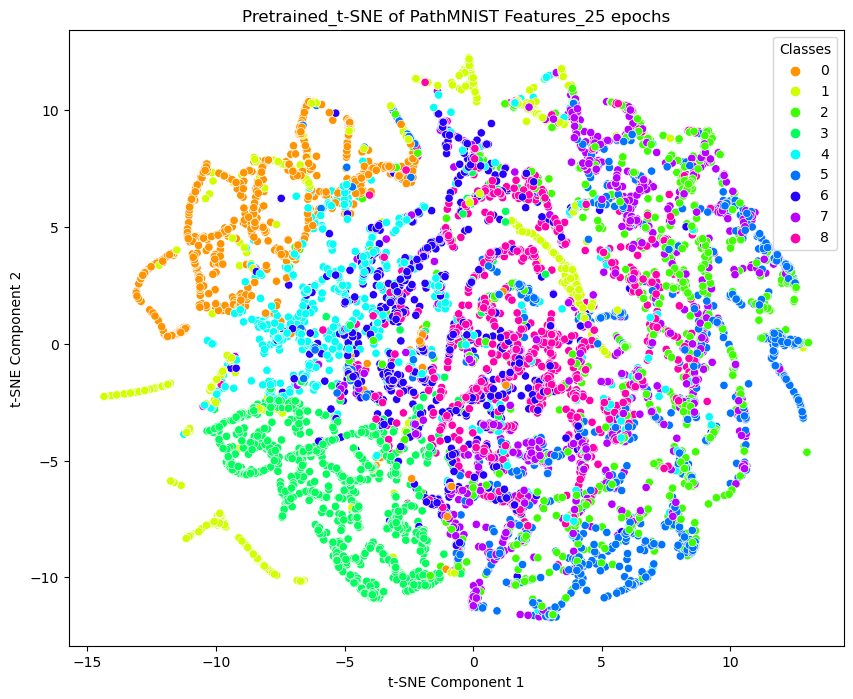

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

# Load features
data = np.load('pathmnist_features_ep_25.npz')
features = data['features']
labels = data['labels']

# Perform t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
features_2d = tsne.fit_transform(features)

# Ensure labels are 1D
labels = labels.squeeze()

# Create a DataFrame with the t-SNE results and labels
df = pd.DataFrame({
    'TSNE1': features_2d[:, 0],
    'TSNE2': features_2d[:, 1],
    'Label': labels
})

# save the df to a csv file
df.to_csv('pathmnist_tsne_ep_50.csv')   ##### ADDDDD

# Visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='Label', legend='full', palette=palette)
plt.title('Pretrained_t-SNE of PathMNIST Features_25 epochs')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Classes')
plt.show()


## Fine-Tuning:

#### We use 1% of the training data for fine-tuning

In [31]:
def get_sub_indices(dataset, proportion=0.01):
    class_indices = {}
    
    for i, data in enumerate(dataset): 
        class_idx = int(data[1][0])
        if class_idx not in class_indices:
            class_indices[class_idx] = []
        class_indices[class_idx].append(i)
    
    # List to store subset indices
    subset_indices = []
        
    # Choose proportionate indices from each class
    for indices in class_indices.values():
        selected_indices = np.random.choice(
            indices, 
            size=int(np.ceil(len(indices) * proportion)),
            replace=False
        ).tolist()  # Ensure indices are in a list format
        subset_indices.extend(selected_indices)

    return subset_indices

In [32]:
# Save the model parameters
torch.save(model.state_dict(), 'simclr_model.pth')

In [33]:
model = SimCLR(base_model='resnet18', out_dim=128).cuda()

# Load the saved model parameters
model.load_state_dict(torch.load('simclr_model.pth'))
model.eval()  # Set the model to evaluation mode


# Extract 1% of training data for fine-tuning
num_samples = len(org_train_dataset)
indices = list(range(num_samples))
np.random.seed(42)
fine_tune_indices = get_sub_indices(org_train_dataset, proportion=0.01)

fine_tune_sampler = torch.utils.data.SubsetRandomSampler(fine_tune_indices)
fine_tune_loader = DataLoader(dataset=org_train_dataset, batch_size=256, sampler=fine_tune_sampler)

# Define a simple classifier for fine-tuning
class FineTuneModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(FineTuneModel, self).__init__()
        self.encoder = base_model.encoder
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        h = self.encoder(x).squeeze()
        logits = self.classifier(h)
        return logits
    
# Convert numpy array to list for getting unique labels
num_classes = 9  #len(set(train_dataset.labels.tolist()))
fine_tune_model = FineTuneModel(model, num_classes).cuda()

# Define the loss function and optimizer for fine-tuning
criterion_fine_tune = nn.CrossEntropyLoss()
optimizer_fine_tune = optim.Adam(fine_tune_model.parameters(), lr=1e-4, weight_decay=1e-6)
# Fine-tuning loop
def fine_tune(model, fine_tune_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()  # Ensure target is 1D
        optimizer.zero_grad()

        # Forward pass
        logits = model(data)
        loss = criterion(logits, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Fine-tune Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
            val_loss, val_accuracy = validate(model, val_loader, criterion)
            print(f'Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

    return val_accuracy, model.state_dict()

# Fine-tuning and validation:
best_val_accuracy = 0.0
best_model_weights = None
fine_tune_epochs = 50

for epoch in range(fine_tune_epochs):
    fine_tune_model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()
        optimizer_fine_tune.zero_grad()
        logits = fine_tune_model(data)
        loss = criterion_fine_tune(logits, target)
        loss.backward()
        optimizer_fine_tune.step()
        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Fine-tune Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')

    train_loss = total_loss / len(fine_tune_loader)
    val_loss, val_accuracy = validate(fine_tune_model, val_loader, criterion_fine_tune)
    print(f'Fine-tune Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = fine_tune_model.state_dict()

fine_tune_model.load_state_dict(best_model_weights)


test_accuracy = evaluate(fine_tune_model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')

/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Fine-tune Epoch 0, Batch 0, Loss: 2.8210651874542236
Fine-tune Epoch 0, Train Loss: 2.4637988209724426, Validation Loss: 1.932668110728264, Validation Accuracy: 0.3402638944422231
Fine-tune Epoch 1, Batch 0, Loss: 1.8799893856048584
Fine-tune Epoch 1, Train Loss: 1.6500698626041412, Validation Loss: 1.3513661295175552, Validation Accuracy: 0.6477409036385445
Fine-tune Epoch 2, Batch 0, Loss: 1.3125289678573608
Fine-tune Epoch 2, Train Loss: 1.1827138364315033, Validation Loss: 1.041384543478489, Validation Accuracy: 0.7744902039184326
Fine-tune Epoch 3, Batch 0, Loss: 0.9832424521446228
Fine-tune Epoch 3, Train Loss: 0.8806588649749756, Validation Loss: 0.8213634207844734, Validation Accuracy: 0.8468612554978009
Fine-tune Epoch 4, Batch 0, Loss: 0.6584418416023254
Fine-tune Epoch 4, Train Loss: 0.6461631655693054, Validation Loss: 0.6400767937302589, Validation Accuracy: 0.8811475409836066
Fine-tune Epoch 5, Batch 0, Loss: 0.4942532181739807
Fine-tune Epoch 5, Train Loss: 0.50729281455

- Validation and see the accuracy result:

In [34]:
def save_features(model, data_loader, filename):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            h = model(data)  # Only get the output from the classifier
            features.append(h.cpu().numpy())
            labels.append(target.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    np.savez(filename, features=features, labels=labels)

# Save features from the fine-tuned model for evaluation
save_features(fine_tune_model, val_loader, 'pathmnist_features_fine_tuned-1.npz')

# Load features
data_fine_tuned = np.load('pathmnist_features_fine_tuned-1.npz')
features_fine_tuned = data_fine_tuned['features']
labels_fine_tuned = data_fine_tuned['labels']

# Split data into training and testing sets
X_train_fine_tuned, X_val_fine_tuned, y_train_fine_tuned, y_val_fine_tuned = train_test_split(features_fine_tuned, labels_fine_tuned, test_size=0.2, random_state=42)

# Standardize the features
scaler_fine_tuned = StandardScaler()
X_train_fine_tuned = scaler_fine_tuned.fit_transform(X_train_fine_tuned)
X_val_fine_tuned = scaler_fine_tuned.transform(X_val_fine_tuned)

# Train logistic regression classifier
classifier_fine_tuned = LogisticRegression(max_iter=1000, random_state=42)
classifier_fine_tuned.fit(X_train_fine_tuned, y_train_fine_tuned)

# Predict on validation set
y_pred_fine_tuned = classifier_fine_tuned.predict(X_val_fine_tuned)

# Calculate accuracy
'''accuracy_fine_tuned = accuracy_score(y_val_fine_tuned, y_pred_fine_tuned)
print(f'Fine-tuned Validation Accuracy: {accuracy_fine_tuned:.4f}')'''

/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


"accuracy_fine_tuned = accuracy_score(y_val_fine_tuned, y_pred_fine_tuned)\nprint(f'Fine-tuned Validation Accuracy: {accuracy_fine_tuned:.4f}')"

### Confusion Matrix:


Using downloaded and verified file: /home/ubuntu/.medmnist/pathmnist.npz


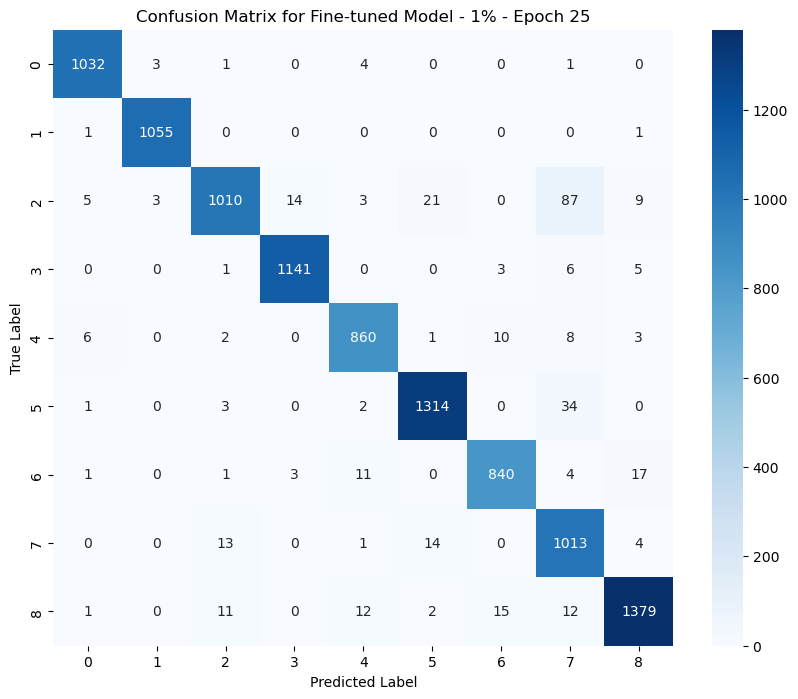

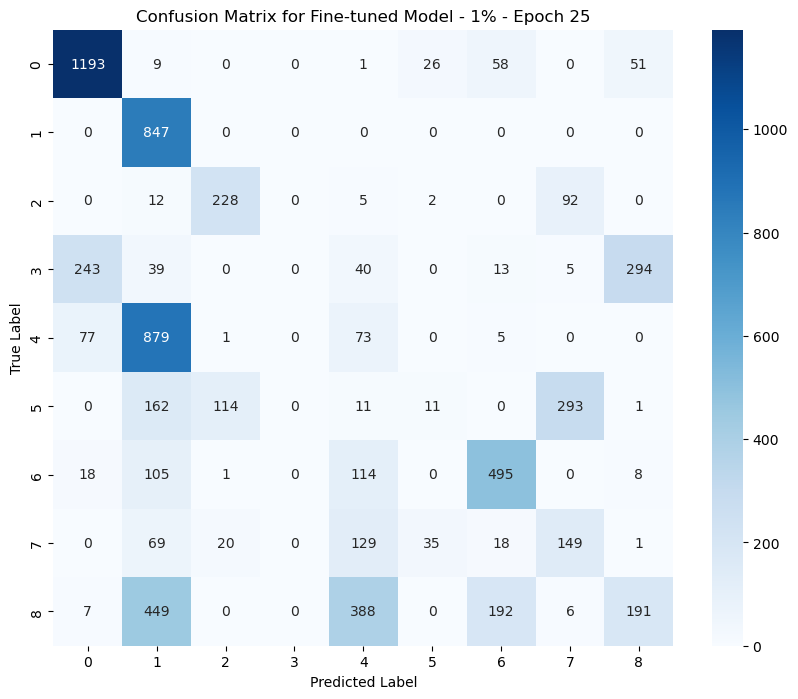

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Computing and plotting the confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for Fine-tuned Model - 1% - Epoch 25')
    plt.show()

test_dataset = DataClass(split='test', transform=org_data_transform, download=download)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

fine_tune_model.load_state_dict(best_model_weights)

def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.cuda(), target.squeeze().long().cuda()
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)


y_val_true, y_val_pred = get_predictions(fine_tune_model, val_loader)
plot_confusion_matrix(y_val_true, y_val_pred, labels_fine_tuned)


y_test_true, y_test_pred = get_predictions(fine_tune_model, test_loader)
plot_confusion_matrix(y_test_true, y_test_pred, labels_fine_tuned)


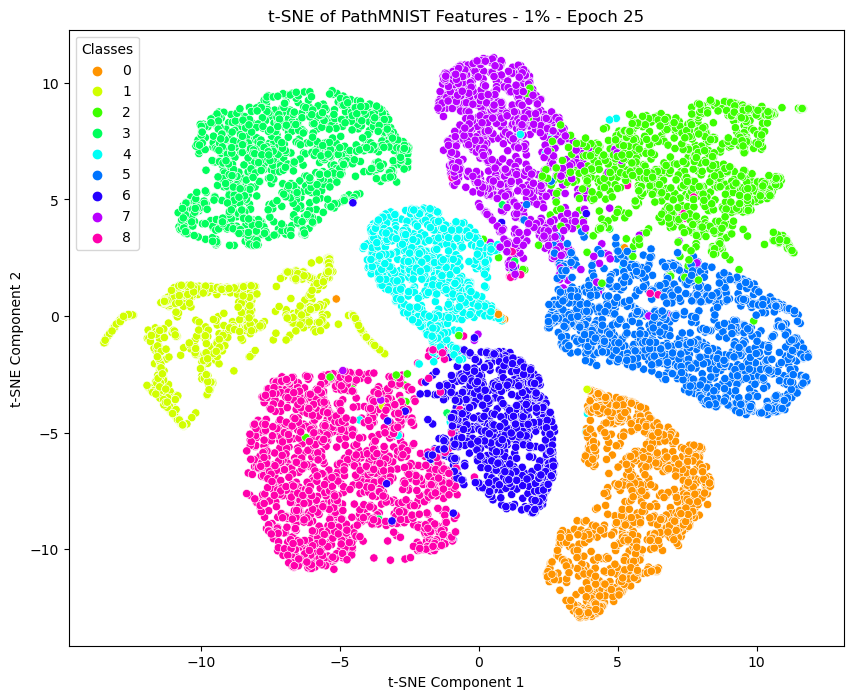

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap.umap_ as umap

data = np.load('pathmnist_features_fine_tuned-1.npz')
'''features = data['features']
labels = data['labels']

umap_reducer = umap.UMAP(n_components=2)
features_2d = umap_reducer.fit_transform(features)

# make sure labels are 1D
labels = labels.squeeze()

df = pd.DataFrame({
    'UMAP1': features_2d[:, 0],
    'UMAP2': features_2d[:, 1],
    'Label': labels
})

# visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='UMAP1', y='UMAP2', hue='Label', legend='full', palette=palette)
plt.title('UMAP of PathMNIST Features')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Classes')
plt.show()'''
features = data['features']
labels = data['labels']

# Perform t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
features_2d = tsne.fit_transform(features)

# Ensure labels are 1D
labels = labels.squeeze()

# Create a DataFrame with the t-SNE results and labels
df = pd.DataFrame({
    'TSNE1': features_2d[:, 0],
    'TSNE2': features_2d[:, 1],
    'Label': labels
})

# SAVE THE DF TO A CSV FILE
df.to_csv('pathmnist_tsne_fine_tuned-1.csv')

# Visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='Label', legend='full', palette=palette)
plt.title('t-SNE of PathMNIST Features - 1% - Epoch 25')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Classes')
plt.show()


#### We use 10% of the training data for fine-tuning

In [37]:
model = SimCLR(base_model='resnet18', out_dim=128).cuda()

# Load the saved model parameters
model.load_state_dict(torch.load('simclr_model.pth'))
model.eval()  # Set the model to evaluation mode


# Extract 10% of training data for fine-tuning
np.random.seed(42)
fine_tune_indices = get_sub_indices(org_train_dataset, proportion=0.1)

fine_tune_sampler = torch.utils.data.SubsetRandomSampler(fine_tune_indices)
fine_tune_loader = DataLoader(dataset=org_train_dataset, batch_size=256, sampler=fine_tune_sampler)

# Define a simple classifier for fine-tuning
class FineTuneModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(FineTuneModel, self).__init__()
        self.encoder = base_model.encoder
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        h = self.encoder(x).squeeze()
        logits = self.classifier(h)
        return logits
# Convert numpy array to list for getting unique labels
num_classes = 9  #len(set(train_dataset.labels.tolist()))
fine_tune_model = FineTuneModel(model, num_classes).cuda()

# Define the loss function and optimizer for fine-tuning
criterion_fine_tune = nn.CrossEntropyLoss()
optimizer_fine_tune = optim.Adam(fine_tune_model.parameters(), lr=1e-4, weight_decay=1e-6)
# Fine-tuning loop
def fine_tune(model, fine_tune_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()  # Ensure target is 1D
        optimizer.zero_grad()

        # Forward pass
        logits = model(data)
        loss = criterion(logits, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Fine-tune Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
    return total_loss / len(fine_tune_loader)

best_val_accuracy = 0.0
best_model_weights = None
fine_tune_epochs = 50

for epoch in range(fine_tune_epochs):
    fine_tune_model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()
        optimizer_fine_tune.zero_grad()
        logits = fine_tune_model(data)
        loss = criterion_fine_tune(logits, target)
        loss.backward()
        optimizer_fine_tune.step()
        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Fine-tune Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')

    train_loss = total_loss / len(fine_tune_loader)
    val_loss, val_accuracy = validate(fine_tune_model, val_loader, criterion_fine_tune)
    print(f'Fine-tune Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = fine_tune_model.state_dict()

fine_tune_model.load_state_dict(best_model_weights)


test_accuracy = evaluate(fine_tune_model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')

/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Fine-tune Epoch 0, Batch 0, Loss: 2.4608922004699707
Fine-tune Epoch 0, Batch 10, Loss: 0.9125134348869324
Fine-tune Epoch 0, Batch 20, Loss: 0.3783835470676422
Fine-tune Epoch 0, Batch 30, Loss: 0.16632002592086792
Fine-tune Epoch 0, Train Loss: 0.7478977719114887, Validation Loss: 0.17856750898063184, Validation Accuracy: 0.969312275089964
Fine-tune Epoch 1, Batch 0, Loss: 0.10971950739622116
Fine-tune Epoch 1, Batch 10, Loss: 0.11143454164266586
Fine-tune Epoch 1, Batch 20, Loss: 0.08708897233009338
Fine-tune Epoch 1, Batch 30, Loss: 0.06638406962156296
Fine-tune Epoch 1, Train Loss: 0.09194706090622479, Validation Loss: 0.09570218082517386, Validation Accuracy: 0.9754098360655737
Fine-tune Epoch 2, Batch 0, Loss: 0.03856511786580086
Fine-tune Epoch 2, Batch 10, Loss: 0.05472526326775551
Fine-tune Epoch 2, Batch 20, Loss: 0.03895314037799835
Fine-tune Epoch 2, Batch 30, Loss: 0.035587191581726074
Fine-tune Epoch 2, Train Loss: 0.051235707838916116, Validation Loss: 0.078656144812703

In [38]:
def save_features(model, data_loader, filename):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            h = model(data)  # Only get the output from the classifier
            features.append(h.cpu().numpy())
            labels.append(target.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    np.savez(filename, features=features, labels=labels)

# Save features from the fine-tuned model for evaluation
save_features(fine_tune_model, val_loader, 'pathmnist_features_fine_tuned-10.npz')
'''
# Load features
data_fine_tuned = np.load('pathmnist_features_fine_tuned-10.npz')
features_fine_tuned = data_fine_tuned['features']
labels_fine_tuned = data_fine_tuned['labels']

# Split data into training and testing sets
X_train_fine_tuned, X_val_fine_tuned, y_train_fine_tuned, y_val_fine_tuned = train_test_split(features_fine_tuned, labels_fine_tuned, test_size=0.2, random_state=42)

# Standardize the features
scaler_fine_tuned = StandardScaler()
X_train_fine_tuned = scaler_fine_tuned.fit_transform(X_train_fine_tuned)
X_val_fine_tuned = scaler_fine_tuned.transform(X_val_fine_tuned)

# Train logistic regression classifier
classifier_fine_tuned = LogisticRegression(max_iter=1000, random_state=42)
classifier_fine_tuned.fit(X_train_fine_tuned, y_train_fine_tuned)

# Predict on validation set
y_pred_fine_tuned = classifier_fine_tuned.predict(X_val_fine_tuned)

# Calculate accuracy
#accuracy_fine_tuned = accuracy_score(y_val_fine_tuned, y_pred_fine_tuned)
#print(f'Fine-tuned Validation Accuracy: {accuracy_fine_tuned:.4f}')'''

"\n# Load features\ndata_fine_tuned = np.load('pathmnist_features_fine_tuned-10.npz')\nfeatures_fine_tuned = data_fine_tuned['features']\nlabels_fine_tuned = data_fine_tuned['labels']\n\n# Split data into training and testing sets\nX_train_fine_tuned, X_val_fine_tuned, y_train_fine_tuned, y_val_fine_tuned = train_test_split(features_fine_tuned, labels_fine_tuned, test_size=0.2, random_state=42)\n\n# Standardize the features\nscaler_fine_tuned = StandardScaler()\nX_train_fine_tuned = scaler_fine_tuned.fit_transform(X_train_fine_tuned)\nX_val_fine_tuned = scaler_fine_tuned.transform(X_val_fine_tuned)\n\n# Train logistic regression classifier\nclassifier_fine_tuned = LogisticRegression(max_iter=1000, random_state=42)\nclassifier_fine_tuned.fit(X_train_fine_tuned, y_train_fine_tuned)\n\n# Predict on validation set\ny_pred_fine_tuned = classifier_fine_tuned.predict(X_val_fine_tuned)\n\n# Calculate accuracy\n#accuracy_fine_tuned = accuracy_score(y_val_fine_tuned, y_pred_fine_tuned)\n#print(f

Using downloaded and verified file: /home/ubuntu/.medmnist/pathmnist.npz


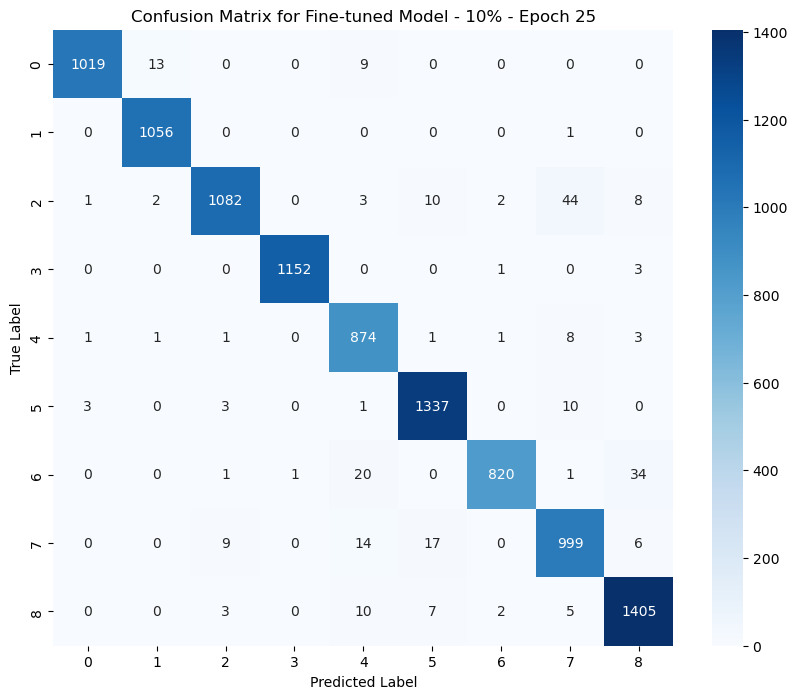

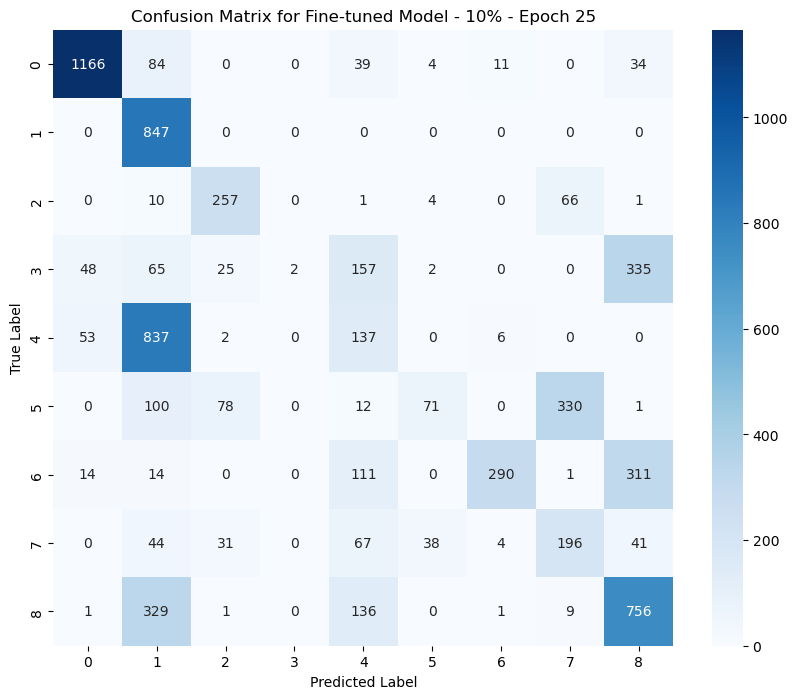

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for Fine-tuned Model - 10% - Epoch 25')
    plt.show()

test_dataset = DataClass(split='test', transform=org_data_transform, download=download)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

fine_tune_model.load_state_dict(best_model_weights)

def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.cuda(), target.squeeze().long().cuda()
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

y_val_true, y_val_pred = get_predictions(fine_tune_model, val_loader)
plot_confusion_matrix(y_val_true, y_val_pred, labels_fine_tuned)

y_test_true, y_test_pred = get_predictions(fine_tune_model, test_loader)
plot_confusion_matrix(y_test_true, y_test_pred, labels_fine_tuned)


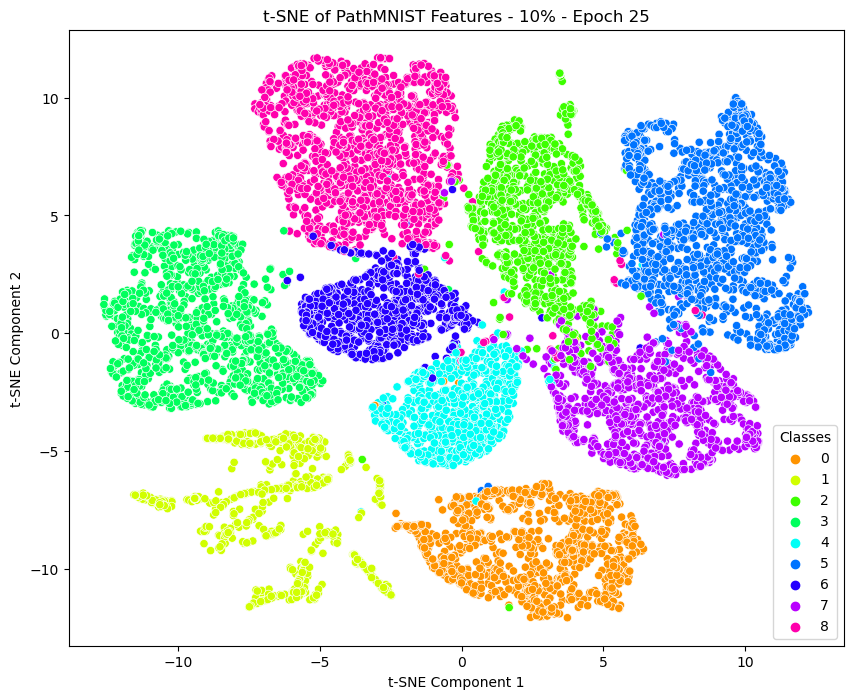

In [40]:
data = np.load('pathmnist_features_fine_tuned-10.npz')
'''features = data['features']
labels = data['labels']

umap_reducer = umap.UMAP(n_components=2)
features_2d = umap_reducer.fit_transform(features)

# make sure labels are 1D
labels = labels.squeeze()

df = pd.DataFrame({
    'UMAP1': features_2d[:, 0],
    'UMAP2': features_2d[:, 1],
    'Label': labels
})

# visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='UMAP1', y='UMAP2', hue='Label', legend='full', palette=palette)
plt.title('UMAP of PathMNIST Features - 10% Fine-tuned')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Classes')
plt.show()'''

features = data['features']
labels = data['labels']

# Perform t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
features_2d = tsne.fit_transform(features)

# Ensure labels are 1D
labels = labels.squeeze()

# Create a DataFrame with the t-SNE results and labels
df = pd.DataFrame({
    'TSNE1': features_2d[:, 0],
    'TSNE2': features_2d[:, 1],
    'Label': labels
})

df.to_csv('pathmnist_tsne_fine_tuned_10.csv')

# Visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='Label', legend='full', palette=palette)
plt.title('t-SNE of PathMNIST Features - 10% - Epoch 25')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Classes')
plt.show()


#### We extract 100% of training data for fine-tuning

In [41]:
model = SimCLR(base_model='resnet18', out_dim=128).cuda()

# Load the saved model parameters
model.load_state_dict(torch.load('simclr_model.pth'))
model.eval()  # Set the model to evaluation mode


# Extract 100% of training data for fine-tuning

# np.random.seed(42)
# fine_tune_indices = get_sub_indices(org_train_dataset, proportion=0.1)

num_samples = len(org_train_dataset)
indices = list(range(num_samples))
np.random.shuffle(indices)
fine_tune_size = int(num_samples)
fine_tune_indices = indices[:fine_tune_size]

fine_tune_sampler = torch.utils.data.SubsetRandomSampler(fine_tune_indices)
fine_tune_loader = DataLoader(dataset=org_train_dataset, batch_size=256, sampler=fine_tune_sampler)

# Define a simple classifier for fine-tuning
class FineTuneModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(FineTuneModel, self).__init__()
        self.encoder = base_model.encoder
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        h = self.encoder(x).squeeze()
        logits = self.classifier(h)
        return logits
# Convert numpy array to list for getting unique labels
num_classes = 9  #len(set(train_dataset.labels.tolist()))
fine_tune_model = FineTuneModel(model, num_classes).cuda()

# Define the loss function and optimizer for fine-tuning
criterion_fine_tune = nn.CrossEntropyLoss()
optimizer_fine_tune = optim.Adam(fine_tune_model.parameters(), lr=1e-4, weight_decay=1e-6)
# Fine-tuning loop
def fine_tune(model, fine_tune_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()  # Ensure target is 1D
        optimizer.zero_grad()

        # Forward pass
        logits = model(data)
        loss = criterion(logits, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Fine-tune Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
    return total_loss / len(fine_tune_loader)


best_val_accuracy = 0.0
best_model_weights = None
fine_tune_epochs = 50

for epoch in range(fine_tune_epochs):
    fine_tune_model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()
        optimizer_fine_tune.zero_grad()
        logits = fine_tune_model(data)
        loss = criterion_fine_tune(logits, target)
        loss.backward()
        optimizer_fine_tune.step()
        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Fine-tune Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')

    train_loss = total_loss / len(fine_tune_loader)
    val_loss, val_accuracy = validate(fine_tune_model, val_loader, criterion_fine_tune)
    print(f'Fine-tune Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = fine_tune_model.state_dict()

fine_tune_model.load_state_dict(best_model_weights)

test_dataset = DataClass(split='test', transform=org_data_transform, download=download)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

test_accuracy = evaluate(fine_tune_model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')


/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/data/anaconda3/envs/pytorch_1_12/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Fine-tune Epoch 0, Batch 0, Loss: 2.3126957416534424


Fine-tune Epoch 0, Batch 10, Loss: 0.9191969037055969
Fine-tune Epoch 0, Batch 20, Loss: 0.41449207067489624
Fine-tune Epoch 0, Batch 30, Loss: 0.2217831015586853
Fine-tune Epoch 0, Batch 40, Loss: 0.15405677258968353
Fine-tune Epoch 0, Batch 50, Loss: 0.11252640187740326
Fine-tune Epoch 0, Batch 60, Loss: 0.09354007989168167
Fine-tune Epoch 0, Batch 70, Loss: 0.0819534882903099
Fine-tune Epoch 0, Batch 80, Loss: 0.051399242132902145
Fine-tune Epoch 0, Batch 90, Loss: 0.05514407157897949
Fine-tune Epoch 0, Batch 100, Loss: 0.03993429243564606
Fine-tune Epoch 0, Batch 110, Loss: 0.06095261126756668
Fine-tune Epoch 0, Batch 120, Loss: 0.030683236196637154
Fine-tune Epoch 0, Batch 130, Loss: 0.02828788012266159
Fine-tune Epoch 0, Batch 140, Loss: 0.03188962861895561
Fine-tune Epoch 0, Batch 150, Loss: 0.02633870393037796
Fine-tune Epoch 0, Batch 160, Loss: 0.03107876144349575
Fine-tune Epoch 0, Batch 170, Loss: 0.03216021507978439
Fine-tune Epoch 0, Batch 180, Loss: 0.030997825786471367
F

In [42]:
def save_features(model, data_loader, filename):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            h = model(data)  
            features.append(h.cpu().numpy())
            labels.append(target.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    np.savez(filename, features=features, labels=labels)


save_features(fine_tune_model, val_loader, 'pathmnist_features_fine_tuned_100.npz')
'''
# Load features
data_fine_tuned = np.load('pathmnist_features_fine_tuned_100.npz')
features_fine_tuned = data_fine_tuned['features']
labels_fine_tuned = data_fine_tuned['labels']

# Split data into training and testing sets
X_train_fine_tuned, X_val_fine_tuned, y_train_fine_tuned, y_val_fine_tuned = train_test_split(features_fine_tuned, labels_fine_tuned, test_size=0.2, random_state=42)

# Standardize the features
scaler_fine_tuned = StandardScaler()
X_train_fine_tuned = scaler_fine_tuned.fit_transform(X_train_fine_tuned)
X_val_fine_tuned = scaler_fine_tuned.transform(X_val_fine_tuned)

# Train logistic regression classifier
classifier_fine_tuned = LogisticRegression(max_iter=1000, random_state=42)
classifier_fine_tuned.fit(X_train_fine_tuned, y_train_fine_tuned)

# Predict on validation set
y_pred_fine_tuned = classifier_fine_tuned.predict(X_val_fine_tuned)

# Calculate accuracy
#accuracy_fine_tuned = accuracy_score(y_val_fine_tuned, y_pred_fine_tuned)
#print(f'Fine-tuned Validation Accuracy: {accuracy_fine_tuned:.4f}')'''

"\n# Load features\ndata_fine_tuned = np.load('pathmnist_features_fine_tuned_100.npz')\nfeatures_fine_tuned = data_fine_tuned['features']\nlabels_fine_tuned = data_fine_tuned['labels']\n\n# Split data into training and testing sets\nX_train_fine_tuned, X_val_fine_tuned, y_train_fine_tuned, y_val_fine_tuned = train_test_split(features_fine_tuned, labels_fine_tuned, test_size=0.2, random_state=42)\n\n# Standardize the features\nscaler_fine_tuned = StandardScaler()\nX_train_fine_tuned = scaler_fine_tuned.fit_transform(X_train_fine_tuned)\nX_val_fine_tuned = scaler_fine_tuned.transform(X_val_fine_tuned)\n\n# Train logistic regression classifier\nclassifier_fine_tuned = LogisticRegression(max_iter=1000, random_state=42)\nclassifier_fine_tuned.fit(X_train_fine_tuned, y_train_fine_tuned)\n\n# Predict on validation set\ny_pred_fine_tuned = classifier_fine_tuned.predict(X_val_fine_tuned)\n\n# Calculate accuracy\n#accuracy_fine_tuned = accuracy_score(y_val_fine_tuned, y_pred_fine_tuned)\n#print(

Using downloaded and verified file: /home/ubuntu/.medmnist/pathmnist.npz


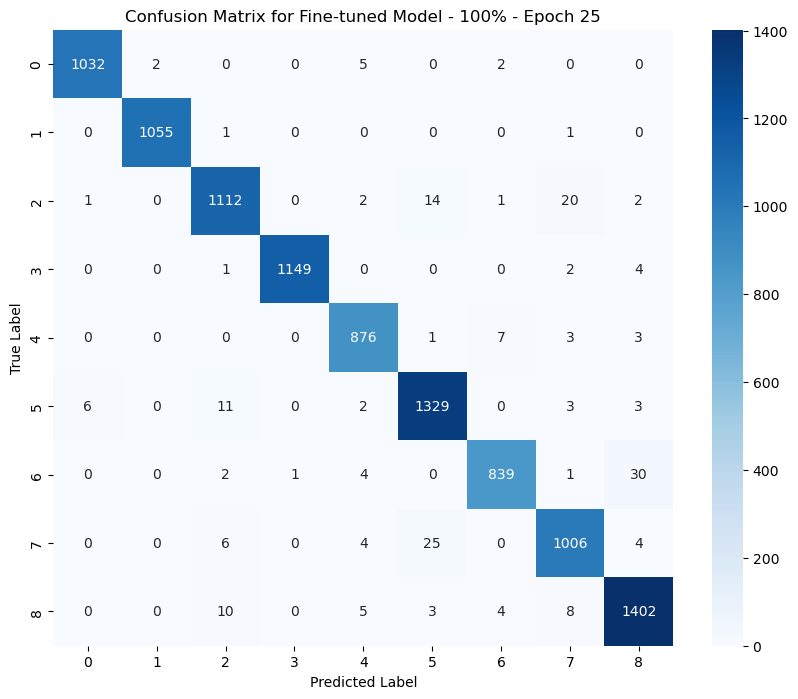

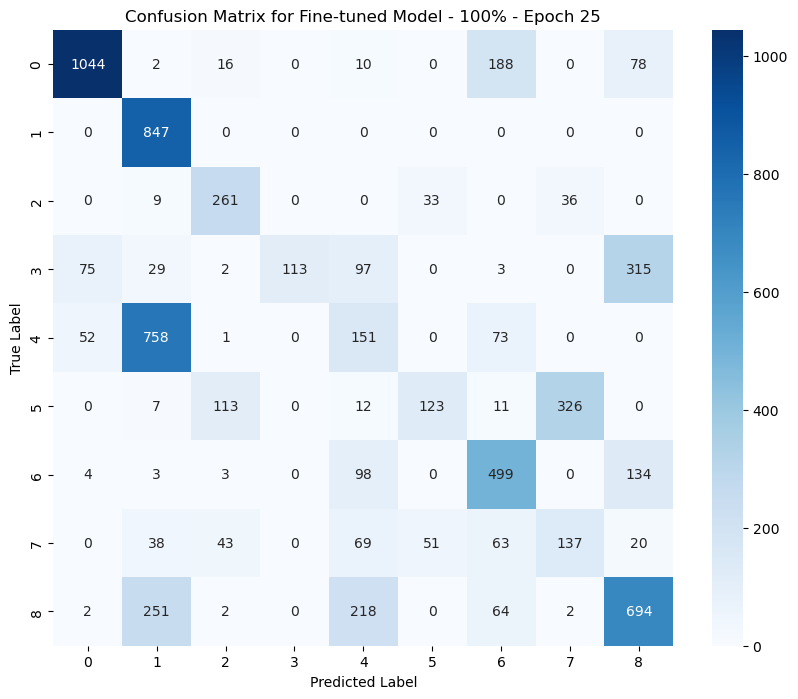

In [43]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for Fine-tuned Model - 100% - Epoch 25')
    plt.show()

test_dataset = DataClass(split='test', transform=org_data_transform, download=download)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

fine_tune_model.load_state_dict(best_model_weights)

def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.cuda(), target.squeeze().long().cuda()
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

torch.save(fine_tune_model.state_dict(), 'fine_tuned_model_100_epoch_50.pth')

y_val_true, y_val_pred = get_predictions(fine_tune_model, val_loader)
plot_confusion_matrix(y_val_true, y_val_pred, labels_fine_tuned)

y_test_true, y_test_pred = get_predictions(fine_tune_model, test_loader)
plot_confusion_matrix(y_test_true, y_test_pred, labels_fine_tuned)


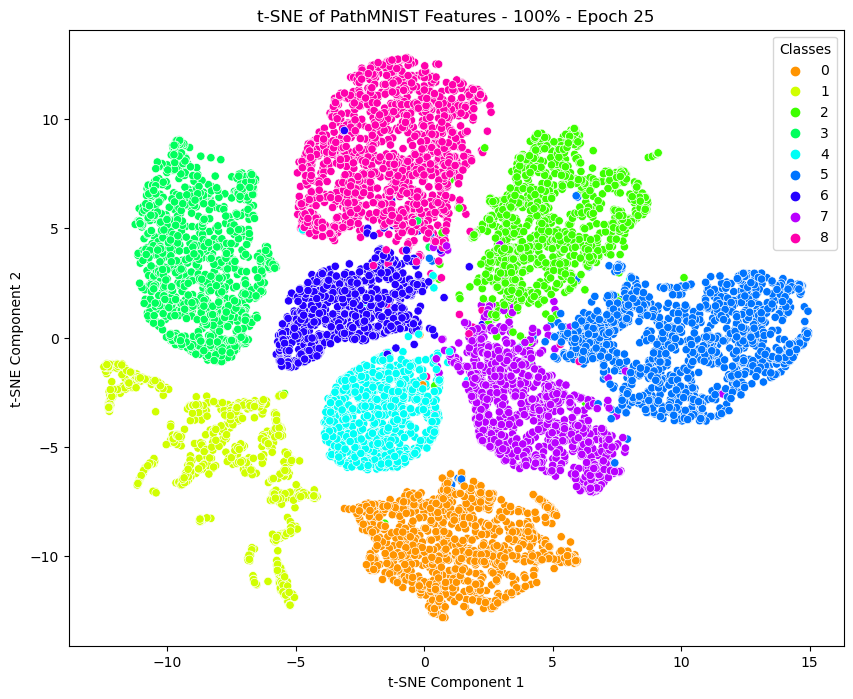

In [44]:
data = np.load('pathmnist_features_fine_tuned_100.npz')
'''features = data['features']
labels = data['labels']

umap_reducer = umap.UMAP(n_components=2)
features_2d = umap_reducer.fit_transform(features)

# make sure labels are 1D
labels = labels.squeeze()

df = pd.DataFrame({
    'UMAP1': features_2d[:, 0],
    'UMAP2': features_2d[:, 1],
    'Label': labels
})

# visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='UMAP1', y='UMAP2', hue='Label', legend='full', palette=palette)
plt.title('UMAP of PathMNIST Features - 100% Fine-tuned')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Classes')
plt.show()'''

features = data['features']
labels = data['labels']

# Perform t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
features_2d = tsne.fit_transform(features)

# Ensure labels are 1D
labels = labels.squeeze()

# Create a DataFrame with the t-SNE results and labels
df = pd.DataFrame({
    'TSNE1': features_2d[:, 0],
    'TSNE2': features_2d[:, 1],
    'Label': labels
})

df.to_csv('pathmnist_tsne_fine_tuned_100.csv') 

# Visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='Label', legend='full', palette=palette)
plt.title('t-SNE of PathMNIST Features - 100% - Epoch 25')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Classes')
plt.show()


------